# Visual Question Answering

## Installing Libraries

In [ ]:
%pip install ftfy regex tqdm --user
%pip install git+https://github.com/openai/CLIP.git --user
%pip install pandas --user
%pip install wordcloud --user
%pip install sklearn --user
%pip install scikit-learn --user
%pip install Levenshtein --user

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117 --user

Looking in indexes: https://download.pytorch.org/whl/cu117
                                              0.0/2.5 MB ? eta -:--:--
                                              0.0/2.5 MB 1.9 MB/s eta 0:00:02
     -                                        0.1/2.5 MB 1.2 MB/s eta 0:00:02
     --                                       0.2/2.5 MB 1.3 MB/s eta 0:00:02
     ---                                      0.2/2.5 MB 1.3 MB/s eta 0:00:02
     -----                                    0.3/2.5 MB 1.3 MB/s eta 0:00:02
     -----                                    0.4/2.5 MB 1.3 MB/s eta 0:00:02
     -------                                  0.4/2.5 MB 1.4 MB/s eta 0:00:02
     --------                                 0.5/2.5 MB 1.4 MB/s eta 0:00:02
     ---------                                0.6/2.5 MB 1.4 MB/s eta 0:00:02
     ----------                               0.6/2.5 MB 1.4 MB/s eta 0:00:02
     -----------                              0.7/2.5 MB 1.4 MB/s eta 0:00:02
     -------

## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import modelArchitecture

## Global Variables

In [2]:
INPUT_PATH = 'vizwiz'
ANNOTATIONS = INPUT_PATH + '/Annotations/Annotations'
TRAIN_PATH = INPUT_PATH + '/train/train'
VALIDATION_PATH = INPUT_PATH + '/val/val'
ANNOTATIONS_TRAIN_PATH = ANNOTATIONS + '/train.json'
ANNOTATIONS_VAL_PATH = ANNOTATIONS + '/val.json'
OUTPUT_PATH = ''
ANSWER_SPACE = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device: ", DEVICE)

Device:  cpu


## Processing Data

In [3]:
def read_dataframe(path):
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers', 'answer_type', 'answerable']]
    return df

def save_dataframe(dataframe, path, type = 'train'):

    path+= 'dataframes' if path =='' else '/dataframes'
    if not os.path.exists(path):
        os.makedirs(path)

    if type == 'train':
        dataframe.to_csv(path + '/train.csv', index=False)
    elif type == 'val':
        dataframe.to_csv(path + '/val.csv', index=False)
    else:
        dataframe.to_csv(path + '/test.csv', index=False)

def split_train_test(dataframe, test_size = 0.05):
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42, stratify=dataframe[['answer_type', 'answerable']])
    return train, test


def plot_histogram(dataframe, column):
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()


def plot_boxplot(dataframe, column):
    plt.boxplot(dataframe[column])
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):

    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(text) 
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

def explore_dataframe(dataframe):

    # let's see the distribution of the answer types
    plot_pie(dataframe, 'answer_type')

    # let's see the distribution of the answerable column
    plot_pie(dataframe, 'answerable')

    # let's plot histograms for the answerable column
    plot_histogram(dataframe, 'answerable')

    # let's see the distribution of the question column
    plot_wordcloud(dataframe, 'question')
    

def get_number_of_distinct_answers(dataframe):
    # Create a set to count the number of unique answers
    unique_answers_set = set()

    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

## Creating Dataframes & Splitting

In [4]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df)
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  39515


## Exploratory Data Analysis

### Training Dataframe

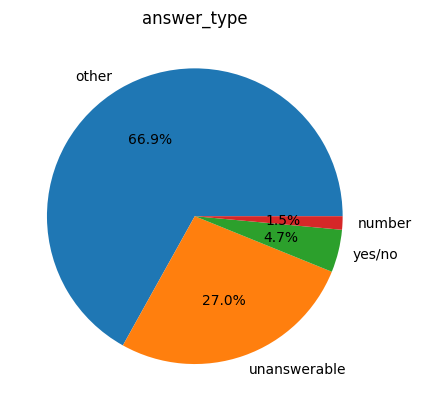

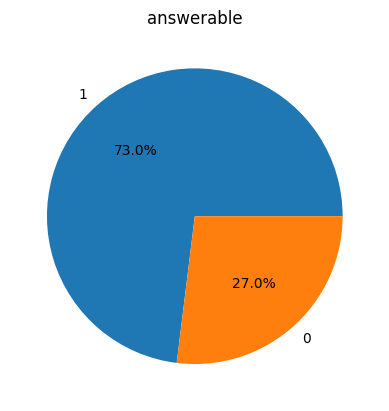

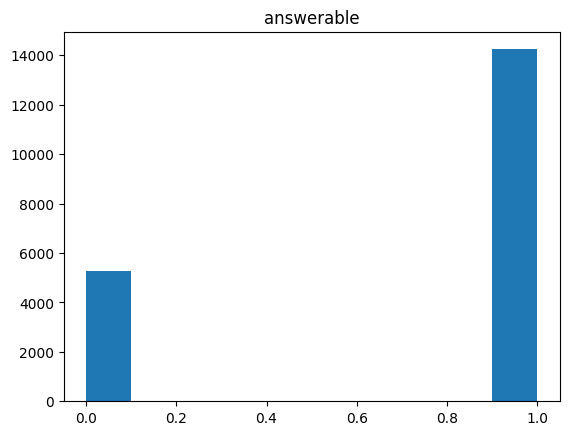

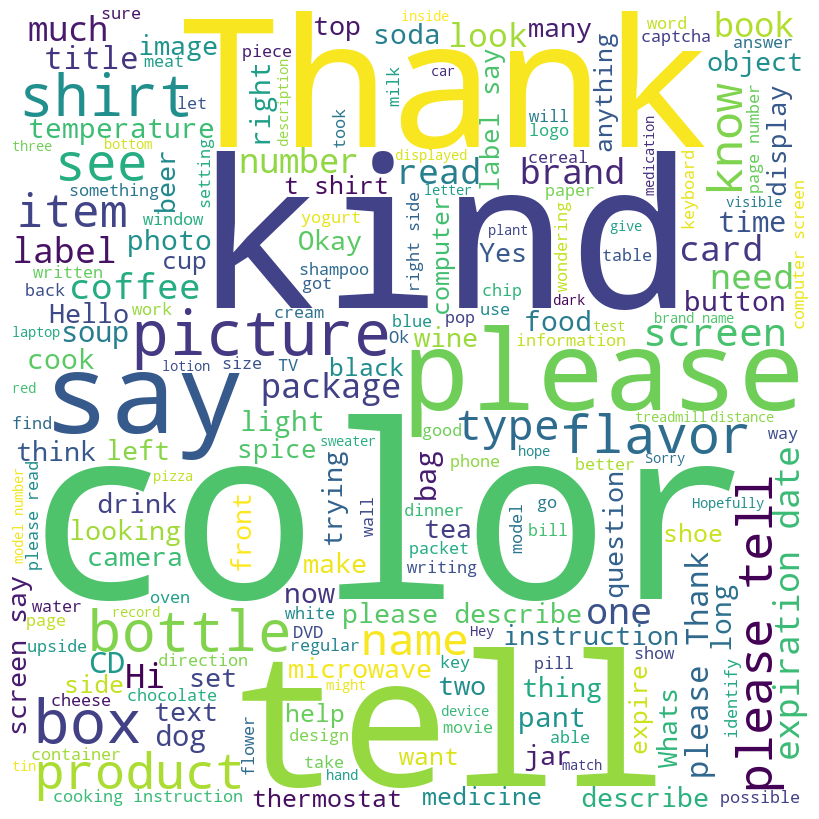

Number of distinct answers:  39515
Number of samples in train:  19496


In [5]:
explore_dataframe(train_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))

### Validation Dataframe

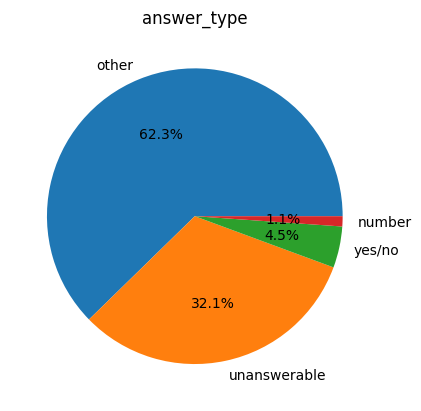

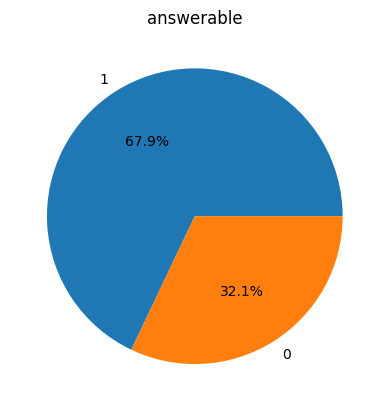

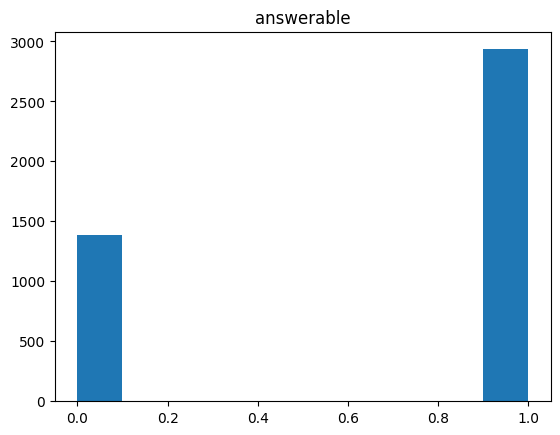

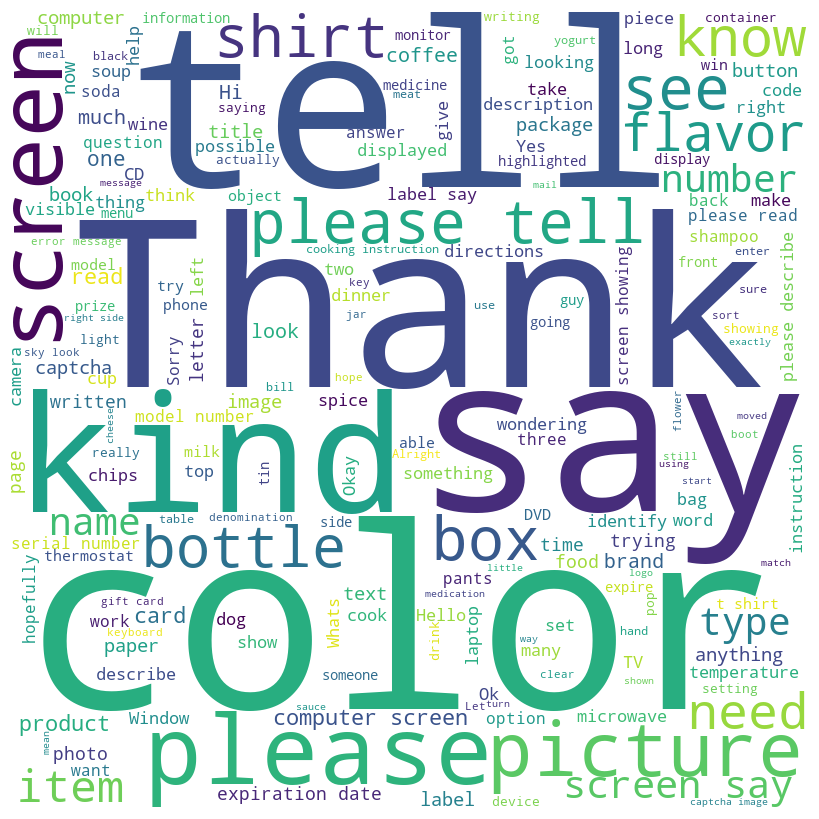

Number of distinct answers:  10905
Number of samples in validation set:  4319


In [6]:
explore_dataframe(validation_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(validation_df))
print("Number of samples in validation set: ", len(validation_df))

### Testing Dataframe

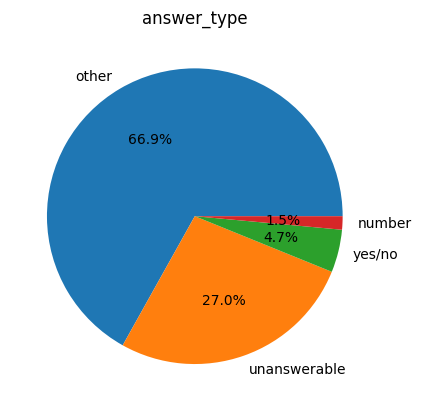

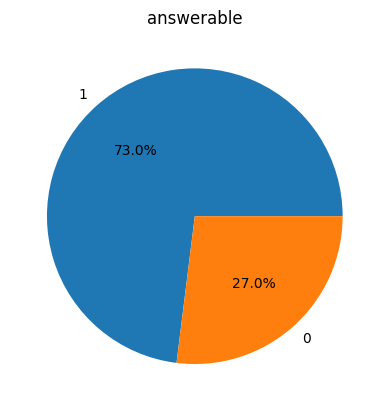

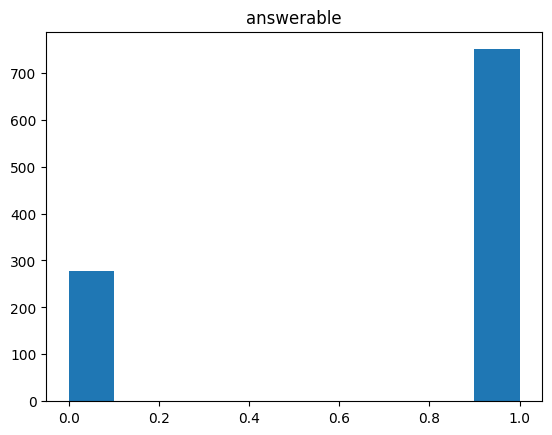

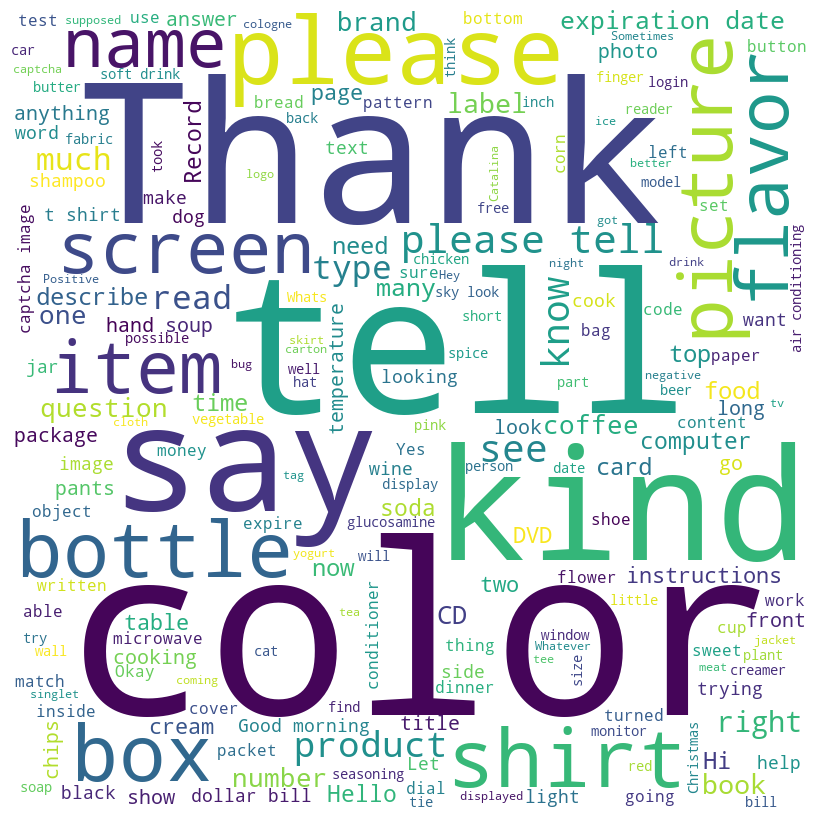

Number of distinct answers:  3007
Number of samples in test:  1027


In [7]:
explore_dataframe(test_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(test_df))
print("Number of samples in test: ", len(test_df))

## Creating Model

## Creating Dataset Class

In [5]:
class VizWizDataset(Dataset):
    def __init__(self, dataframe, image_path = "", answer_type_onehotencoder = None, answer_onehotencoder = None, device =torch.device("cpu"), model_name = "RN50x64"):

        super(VizWizDataset, self).__init__()
        self.answer_counter = Counter()
        self.dataframe = dataframe
        self.image_path = image_path
        self.device = device
        self.clip_model, self.preprocess = clip.load(model_name, device = device)
               
        self.build_answer_counter()
        self.build_answer_vocab()
        # the columns of the dataframe are: image, question, answer, answer_type, answerable
        print("Number of distinct answers: ", len(self.get_answer_vocab()))

        # Now we should one-hot encode the answer and the answer type

        if answer_type_onehotencoder is None:
            answer_type_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_type_onehotencoder.fit(self.dataframe[['answer_type']])
            self.answer_type_onehotencoder = answer_type_onehotencoder
        else:
            self.answer_type_onehotencoder = answer_type_onehotencoder

        if answer_onehotencoder is None:
            answer_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_onehotencoder.fit(self.dataframe[['answer']])
            self.answer_onehotencoder = answer_onehotencoder
        else:
            self.answer_onehotencoder = answer_onehotencoder
        
        self.answer_onehotencoded = answer_onehotencoder.transform(self.dataframe[['answer']]).toarray()
        self.answer_type_onehotencoded = answer_type_onehotencoder.transform(self.dataframe[['answer_type']]).toarray()


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        full_path = self.image_path + "/" + self.dataframe.iloc[index]['image']
        image = Image.open(full_path)
        question = self.dataframe.iloc[index]['question']
        
        answer = torch.tensor(self.answer_onehotencoded[index], dtype=torch.float32)
        answer_type = torch.tensor(self.answer_type_onehotencoded[index], dtype=torch.float32)

        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_features = self.clip_model.encode_image(image)
        
        question =  clip.tokenize(question).to(self.device)
        text_features = self.clip_model.encode_text(question).float()
        
        return image_features, text_features, answer, answer_type
    
    def build_answer_vocab(self):
        # This function assigns answer for each row in the dataframe and builds the answer vocab

        # Building answer vocab follow this policy:
        # for each 10 answers for a question, we choose the most frequent answer
        # if there is a tie, we choose the most common one in the whole dataset
        # if there is a tie, we choose the pairwise Levenshtein distance is used to find the answer that is most representative to all others.
        
        
        # let's copy the original dataframe
        copied_dataframe = self.dataframe.copy()
        copied_dataframe.drop(columns=['answers'], inplace=True)

        # add extra column named 'answer'
        copied_dataframe['answer'] = None

        for index, row in self.dataframe.iterrows():
            intermediate_counter = Counter()
            for answer_map in row['answers']:
                answer = answer_map['answer']
                intermediate_counter.update([answer])

            # let's see the top elements in the answers_counter to check if there is a tie
            top_elements = intermediate_counter.most_common(1)
            if len(top_elements) == 1:
                copied_dataframe.at[index, 'answer'] = top_elements[0][0]
            else:
                # let's see who is the most common answer in the whole dataset
                top_elements = self.answer_counter.most_common(1)
                if len(top_elements) == 1:
                    copied_dataframe.at[index, 'answer'] = top_elements[0][0]
                else:
                    # let's get the minimum levenshtein distance which we have built before
                    current_min = np.inf
                    current_answer = None
                    # now let's build levenshtein distance between the answers in top_elements and each others and select the minimum
                    for answer in top_elements:
                        total_distance = 0
                        for answer2 in top_elements:
                            if answer != answer2:
                                lev_distance = lev.distance(answer[0], answer2[0])
                                total_distance += lev_distance
                        if total_distance < current_min:
                            current_min = total_distance
                            current_answer = answer[0]
                    copied_dataframe.at[index, 'answer'] = current_answer

        # now let's replace the original dataframe with the new one
        self.dataframe = copied_dataframe
        return

    def build_answer_counter(self):
        for row in self.dataframe['answers']:
            for answer_map in row:
                self.answer_counter.update([answer_map['answer']])
    
    def get_answer_vocab(self):
        return self.dataframe['answer'].unique()
    
    def reverse_onehotencode_answer(self, answer_one_hot_encoded, answer_type_one_hot_encoded):
        answer = self.answer_onehotencoder.inverse_transform(answer_one_hot_encoded)
        answer_type = self.answer_type_onehotencoder.inverse_transform(answer_type_one_hot_encoded)
        return answer, answer_type

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "RN50x64"

training_dataset = VizWizDataset(train_df, TRAIN_PATH, None, None, DEVICE, MODEL_NAME)

ANSWER_ONEHOTENCODER = training_dataset.answer_onehotencoder
ANSWER_TYPE_ONEHOTENCODER = training_dataset.answer_type_onehotencoder

validation_dataset = VizWizDataset(validation_df, VALIDATION_PATH, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, DEVICE, MODEL_NAME)
test_dataset = VizWizDataset(test_df, TRAIN_PATH, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, DEVICE, MODEL_NAME)

BATCH_SIZE = 16
NUM_WORKERS = 4

training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Number of distinct answers:  5410
Number of distinct answers:  1531
Number of distinct answers:  489


## Training Model

In [7]:
NUM_EPOCHS = 10
LR = 0.0001
NUM_CLASSES = len(training_dataset.get_answer_vocab())
SAVE_PATH = OUTPUT_PATH
SAVE_EVERY = 1

print("Device: ", DEVICE)

model = modelArchitecture.VQAModel(num_classes=NUM_CLASSES, device= DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
#model.print_CLIP_model()

# let's define the loss function
loss_function = nn.CrossEntropyLoss().to(DEVICE)

# let's define the optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

model.train_model(training_dataloader, validation_dataloader, loss_function, optimizer, epochs=NUM_EPOCHS, save_path=SAVE_PATH, save_every=SAVE_EVERY)

Device:  cpu


## Test your own image !

In [ ]:
QUESTION = "What is the color of the shirt?"
IMAGE_PATH = ""
model.test_model(image_path = IMAGE_PATH, question = QUESTION)